# Educational Toolkit for Mapping Large Ensembles

This is an educational toolkit to demonstrate how to deal with CESM1 data. 

Things to note: 

- We are using the Ocean model from CESM1
- The data is hosted on Amazon Web Services (AWS), however this data is freely available so no account for AWS is necessary.
- We are investigating different experiments through the Ocean Model.
- We are only looking at few variables. All variables available through the CESM1 data are found on the link below: 
https://www.cesm.ucar.edu/community-projects/lens2/output-variables

## Data Access

This section shows a detailed description and a step-by-step process of accessing the CESM1 data catalog through Pangeo tuturials on AWS. 

Here we are: 

- Accessing the OCN model dataset with RCP 8.5 and 20C runs. 
- Narrowing down the columns to specific variables we aim to access.

For example: 
``` 
col_ocntemp = col.search(
    frequency=["monthly"],
    component="ocn",
    variable="TEMP",
    experiment=["20C", "RCP85"],  
)
```
- Loading in lat/lon data separately which was not in CESM1 as of March 2024. 

This section works similar to accessing other catalogs, we will be using Zarr. More information on the library below.

https://zarr.readthedocs.io/en/stable/

In [18]:
# Packages needed generally
from matplotlib import pyplot as plt
import xarray as xr
import pandas as pd
import geopandas as gpd
import cartopy.crs as ccrs

# Packages needed for CESM1 example
import pprint
import intake
import requests
import aiohttp
import s3fs

# Packages needed for CMIP6
import zarr
import gcsfs
import dask

In [19]:
# Open original collection description file: CESM1 LENS
cat_url = "https://ncar-cesm-lens.s3-us-west-2.amazonaws.com/catalogs/aws-cesm1-le.json"
col = intake.open_esm_datastore(cat_url)
col

# Location of file containing grid (lat/lon) information for CESM1 LENS
grid_url="s3://ncar-cesm-lens/ocn/static/grid.zarr"

In [20]:
# Search for the TEMP variable, display the first few entries in the resulting data frame
col.search(component="ocn").df

,variable,long_name,component,experiment,frequency,vertical_levels,spatial_domain,units,start_time,end_time,path
0,DIC,dissolved inorganic carbon,ocn,20C,monthly,60.0,global_ocean,mmol/m^3,1920-01-16 12:00:00,2005-12-16 12:00:00,s3://ncar-cesm-lens/ocn/monthly/cesmLE-20C-DIC...
1,DOC,dissolved organic carbon,ocn,20C,monthly,60.0,global_ocean,mmol/m^3,1920-01-16 12:00:00,2005-12-16 12:00:00,s3://ncar-cesm-lens/ocn/monthly/cesmLE-20C-DOC...
2,FW,freshwater flux,ocn,20C,monthly,1.0,global_ocean,centimeter/s,1920-01-16 12:00:00,2005-12-16 12:00:00,s3://ncar-cesm-lens/ocn/monthly/cesmLE-20C-FW....
3,HMXL,mixed-layer depth,ocn,20C,monthly,1.0,global_ocean,centimeter,1920-01-16 12:00:00,2005-12-16 12:00:00,s3://ncar-cesm-lens/ocn/monthly/cesmLE-20C-HMX...
4,O2,dissolved oxygen,ocn,20C,monthly,60.0,global_ocean,mmol/m^3,1920-01-16 12:00:00,2005-12-16 12:00:00,s3://ncar-cesm-lens/ocn/monthly/cesmLE-20C-O2....
...,...,...,...,...,...,...,...,...,...,...,...
123,WVEL,vertical velocity,ocn,RCP85,monthly,60.0,global_ocean,centimeter/s,2006-01-16 12:00:00,2100-12-16 12:00:00,s3://ncar-cesm-lens/ocn/monthly/cesmLE-RCP85-W...
124,NaN,NaN,ocn,CTRL,static,NaN,global_ocean,NaN,NaN,NaN,s3://ncar-cesm-lens/ocn/static/grid.zarr
125,NaN,NaN,ocn,HIST,static,NaN,global_ocean,NaN,NaN,NaN,s3://ncar-cesm-lens/ocn/static/grid.zarr
126,NaN,NaN,ocn,RCP85,static,NaN,global_ocean,NaN,NaN,NaN,s3://ncar-cesm-lens/ocn/static/grid.zarr


In [21]:
# Get more detailed: search for monthly output for the 20th century and RCP8.5 
# ("HIST" is the 1850-1919 period, which is only in the first ensemble member, and "20C" is 1920-2005 which is common across all the other members = 
col_ocntemp = col.search(
    frequency=["monthly"],
    component="ocn",
    variable="SST",
    experiment=["20C", "RCP85", "HIST"],  
)

col_ocntemp.df

,variable,long_name,component,experiment,frequency,vertical_levels,spatial_domain,units,start_time,end_time,path
0,SST,potential temperature,ocn,20C,monthly,1.0,global_ocean,degC,1920-01-16 12:00:00,2005-12-16 12:00:00,s3://ncar-cesm-lens/ocn/monthly/cesmLE-20C-SST...
1,SST,potential temperature,ocn,HIST,monthly,1.0,global_ocean,degC,1850-01-16 12:00:00,1919-12-16 12:00:00,s3://ncar-cesm-lens/ocn/monthly/cesmLE-HIST-SS...
2,SST,potential temperature,ocn,RCP85,monthly,1.0,global_ocean,degC,2006-01-16 12:00:00,2100-12-16 12:00:00,s3://ncar-cesm-lens/ocn/monthly/cesmLE-RCP85-S...


In [22]:
# Load catalog entries for subset into a dictionary of xarray datasets
dsets = col_ocntemp.to_dataset_dict(
    zarr_kwargs={"consolidated": True}, storage_options={"anon": True}
)
print(f"\nDataset dictionary keys:\n {dsets.keys()}")


--> The keys in the returned dictionary of datasets are constructed as follows:
	'component.experiment.frequency'



Dataset dictionary keys:
 dict_keys(['ocn.HIST.monthly', 'ocn.RCP85.monthly', 'ocn.20C.monthly'])


In [23]:
# Get file containing lat/lon grid information: s3://ncar-cesm-lens/ocn/static/grid.zarr
fs = s3fs.S3FileSystem(anon=True)
grid = xr.open_zarr(fs.get_mapper(grid_url), consolidated=True)

grid

<xarray.Dataset>
Dimensions:               (nlat: 384, nlon: 320, z_t: 60, z_w: 60,
                           lat_aux_grid: 395, moc_comp: 3, moc_z: 61,
                           transport_comp: 5, transport_reg: 2, z_t_150m: 15,
                           z_w_bot: 60, z_w_top: 60)
Coordinates: (12/63)
    ANGLE                 (nlat, nlon) float64 dask.array<chunksize=(192, 160), meta=np.ndarray>
    ANGLET                (nlat, nlon) float64 dask.array<chunksize=(192, 160), meta=np.ndarray>
    DXT                   (nlat, nlon) float64 dask.array<chunksize=(192, 160), meta=np.ndarray>
    DXU                   (nlat, nlon) float64 dask.array<chunksize=(192, 160), meta=np.ndarray>
    DYT                   (nlat, nlon) float64 dask.array<chunksize=(192, 160), meta=np.ndarray>
    DYU                   (nlat, nlon) float64 dask.array<chunksize=(192, 160), meta=np.ndarray>
    ...                    ...
    vonkar                float64 ...
  * z_t                   (z_t) float32 500.0 1.5e+03 ... 5.125e+05 5.375e+05
  * z_t_150m              (z_t_150m) float32 500.0 1.5e+03 ... 1.35e+04 1.45e+04
  * z_w                   (z_w) float32 0.0 1e+03 2e+03 ... 5e+05 5.25e+05
  * z_w_bot               (z_w_bot) float32 1e+03 2e+03 ... 5.25e+05 5.5e+05
  * z_w_top               (z_w_top) float32 0.0 1e+03 2e+03 ... 5e+05 5.25e+05
Dimensions without coordinates: nlat, nlon, moc_comp, transport_comp,
                                transport_reg
Data variables:
    *empty*

In [35]:
# Define Xarray datasets corresponding to the two experiments
ds_20C = dsets["ocn.20C.monthly"]
ds_RCP85 = dsets["ocn.RCP85.monthly"]
ds_HIST = dsets["ocn.HIST.monthly"]

#ds_HIST
ds_HIST

<xarray.Dataset>
Dimensions:     (time: 840, z_t: 1, nlat: 384, nlon: 320, d2: 2)
Coordinates:
    member_id   int64 ...
  * time        (time) object 1850-01-16 12:00:00 ... 1919-12-16 12:00:00
    time_bound  (time, d2) object dask.array<chunksize=(840, 2), meta=np.ndarray>
  * z_t         (z_t) float32 500.0
Dimensions without coordinates: nlat, nlon, d2
Data variables:
    SST         (time, z_t, nlat, nlon) float32 dask.array<chunksize=(300, 1, 384, 320), meta=np.ndarray>
Attributes: (12/25)
    Conventions:                       CF-1.0; http://www.cgd.ucar.edu/cms/ea...
    NCO:                               4.4.4
    calendar:                          All years have exactly  365 days.
    cell_methods:                      cell_methods = time: mean ==> the vari...
    contents:                          Diagnostic and Prognostic Variables
    nco_openmp_thread_number:          1
    ...                                ...
    intake_esm_attrs:units:            degC
    intake_esm_attrs:start_time:       1850-01-16 12:00:00
    intake_esm_attrs:end_time:         1919-12-16 12:00:00
    intake_esm_attrs:path:             s3://ncar-cesm-lens/ocn/monthly/cesmLE...
    intake_esm_attrs:_data_format_:    zarr
    intake_esm_dataset_key:            ocn.HIST.monthly

We will select dim = "member_id" to access the different ensemble members. 

## Data Exploration

In this part of the tutorial we will conduct preliminary data exploration to understand the large ensembles we are working with. This data is extremely large, so most of our data exploration is shown through "lazyloading." 

Here we can explore different variables, and the column names.

## Data Wrangling

Although data that is made avaiable through the CESM1 model is clean and ready to use, we only want to extract a certain part of the world. This is the Channel Islands Marine Sanctuary and surrounding areas.  


In this section we will demonstrate how to: 

- Merge the grid data and the CESM1 data from the catalog.
- Use `mask` to subset the data from the Channel Islands, more specifically latitude and longitude. 
- Clarify you have extracted the proper data. 

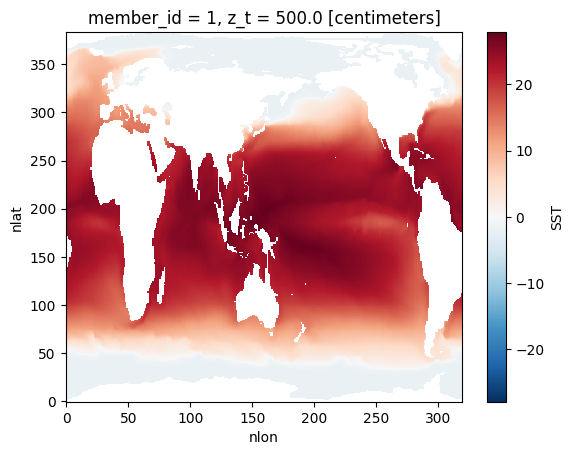

In [44]:
#Let's find the mean of SST by specifying the dimension over which to take the mean
ds_20C_mean=ds_20C.mean(dim="member_id")
ds_RCP85_mean=ds_RCP85.mean(dim="member_id")
ds_HIST_mean=ds_HIST.mean(dim="time")

#lets find the max SST temperture for the 20th century
ds_20C_max=ds_20C.max(dim="member_id")
#now lets repeat the same process for RCP85 runs 
ds_RCP85_max=ds_RCP85.max(dim="member_id")
ds_HIST_max=ds_HIST.max(dim="time")

#now lets find the min for both 
ds_20C_min=ds_20C.min(dim="member_id")
ds_RCP85_min=ds_RCP85.min(dim="member_id")
ds_HIST_min=ds_HIST.min(dim="time")

#now lest zero into time for each of the datasets
test_mean20C = ds_20C_mean.SST.sel(time=slice("1920", "2005"))
test_meanRCP= ds_RCP85_mean.SST.sel(time=slice("2006", "2100"))
test_meanHIST= ds_HIST_mean.SST

test_max20C = ds_20C_max.SST.sel(time=slice("1920", "2005"))
test_maxRCP= ds_RCP85_max.SST.sel(time=slice("2006", "2100"))
test_maxHIST= ds_HIST_max.SST

test_min20C = ds_20C_min.SST.sel(time=slice("1920", "2005"))
test_minRCP= ds_RCP85_min.SST.sel(time=slice("2006", "2100"))
test_minHIST= ds_HIST_min.SST

#lets pick our desired month-- you can choose to plot the entire mean but this may take a while so instead we will pick a month
test_mean20C = ds_20C_mean.sel(time='1950-03')
test_meanRCP = ds_RCP85_mean.sel(time='2050-03')

#test out a random 
test_minHIST.plot()

## Plotting Visuals

Plotting the type of vizualization method, in this section we are mapping the variables. 

This section shows how to properly display the spatial distribution of the variables you are plotting. We will demonstrate some difference plots and maps of data from certain time frames. 